In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from sklearn import model_selection
from mel import cross_valid

In [2]:
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                                "Condition":"condition",
                                "Question":"question_id",
                                "X1":"ss_x",
                                "T1":"ss_t",
                                "X2":"ll_x",
                                "T2":"ll_t",
                                "LaterOptionChosen": "choice"}).\
                drop(['R','G','D'],axis=1)


# Define features, label, and group variable
features = ['ss_x', 'ss_t', 'll_x', 'll_t',
            'abs_diff_x', 'abs_diff_t', 'rel_diff_x','rel_diff_t',
            'growth_x']
label = 'choice'
group = 'person_id'

# Omit the choice questions of which ss_x <= 5
# After omission, 9 persons that answers less than 10 questions (maximum is 23 questions)
# Removew these persons from the dataset
# Retain 65.7% of the obs.
dataset = itch_dt[itch_dt['ss_x'] > 5]
count_indvd_choice = dataset.groupby('person_id').choice.count()
person_id_omit = list(count_indvd_choice[count_indvd_choice <= 10].index)
dataset = dataset[~dataset['person_id'].isin(person_id_omit)]

data_prepare = cross_valid.data_prepare(data=dataset,feature=features,label=label,group=group)
data_prepare.generate_features()
dataset = data_prepare._data

# Split the data into train sample and test sample
# Train sample containts 80% of the participants, test sample contains the rest 
X_train,X_test,y_train,y_test = data_prepare.split_sample(test_size=0.2)
groups = data_prepare.train_sample[group]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=X_train,y=y_train,groups=groups))

In [3]:
len(dataset)/len(itch_dt)

0.6574893617021277

In [18]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
# The following dictionary directly shows the tuning results 
param_grid = {'n_estimators': [35],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.6],
              'reg_lambda': [.6],
              'subsample': [.7],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, 
                                           cv=cv, 
                                           scoring=["accuracy","neg_log_loss",'neg_mean_absolute_error','neg_mean_squared_error'], 
                                           refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=X_train,y=y_train,groups=groups)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 12328, 12329, 12330]),
                  array([   14,    15,    16, ..., 12242, 12243, 12244])),
                 (array([    0,     1,     2, ..., 12328, 12329, 12330]),
                  array([   88,    89,    90, ..., 12227, 12228, 12229])),
                 (array([   14,    15,    16, ..., 12328, 12329, 12330]),
                  array([    0,     1,     2, ..., 11933, 11934, 11935])),
                 (array([    0,     1,     2, ..., 12328, 12329, 12330]),
                  array([  103,   104,   105, ..., 12154, 12155, 12156])),
                 (array([    0,     1,     2,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.6],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [35], 'reg_lambda': [0.6],
                         'subsample': [0.7]},
             refit='neg_log_loss',
             scoring=['accuracy', 'neg_log_loss', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'],
             verbose=3)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

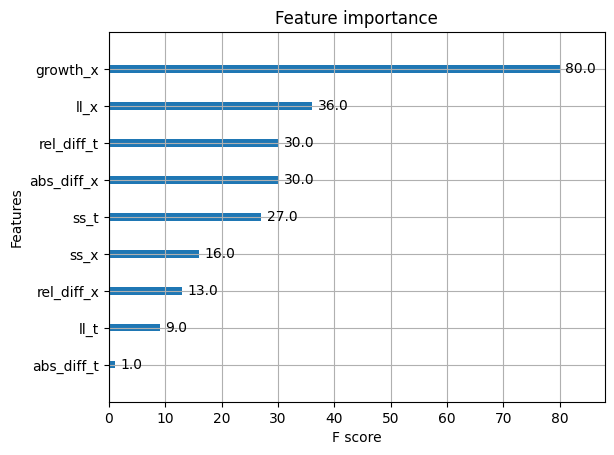

In [19]:
# Save the XGBoost model and check the feature importance
bst_model = grid_search.best_estimator_

with open('my_model_follow_2.pkl', 'wb') as f:
    pickle.dump(bst_model, f)


heuristic_kf_dict = {'dstyle': 'heuristic',
            'ustyle': '--',
            'params': None,
            'accuracy': grid_search.cv_results_['mean_test_accuracy'][0],
            'log_loss': -grid_search.cv_results_['mean_test_neg_log_loss'][0],
            'mse':-grid_search.cv_results_['mean_test_neg_mean_squared_error'][0],
            'mae':-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][0]
            }

xgb.plot_importance(bst_model)

In [19]:
# Plot a decision tree
# To check structure of different trees, change num_trees 
#xgb.to_graphviz(bst_model, num_trees=1)

In [20]:
# Fit data by distounted utility model and trade-off model
style_list = cross_valid.estimation.gen_style_list()
train_sample = data_prepare.train_sample

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [28:02<00:00,  7.65s/it]


In [21]:
# Check if some of the fits fail to converge 
np.where(kf.success==False)

(array([], dtype=int64),)

In [22]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result = kf_result_df.drop('style',axis=1)
kf_result = pd.concat([kf_result,pd.DataFrame(heuristic_kf_dict,index=[99])]).sort_values('log_loss')
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
99,heuristic,--,None,0.274946,0.274946,0.561789,0.725054,NaN
21,trade,power,"[0.632, 1.274, 17.074, 0.85, 0.106, 0.1]",0.194450,0.388525,0.575550,0.715991,0.210756
13,hbmd,power,"[9.485, 0.127, 0.144]",0.197199,0.395245,0.582793,0.721651,0.219777
17,quasihb,power,"[0.998, 0.998, 0.008, 0.005]",0.197443,0.394667,0.582813,0.717033,0.227863
19,quasihb_fc,power,"[0.998, 0.997, 1.066, 0.009, 0.005]",0.197470,0.394102,0.582907,0.717033,0.227863
7,expo2,power,"[0.802, 0.838, 0.451, 0.012, 0.008]",0.197826,0.395610,0.583598,0.713896,0.232013
3,attention_uni,power,"[0.221, 0.018, 0.012]",0.197736,0.396185,0.583675,0.720242,0.221804
11,hb2,power,"[0.129, 2.271, 0.015, 0.01]",0.198813,0.398776,0.585876,0.714245,0.238172
15,hce,power,"[0.997, 2.067, 0.005, 0.005]",0.199363,0.399334,0.587255,0.716431,0.244497
9,hb,power,"[0.002, 0.006, 0.004]",0.199359,0.398990,0.587294,0.714816,0.251120


In [24]:
# Compare models: Out-of-sample performance
test_sample = data_prepare.test_sample
test_result = cross_valid.get_result_tab(kf_result_df,test_sample)

with open('my_model_follow_2.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

heuristic_test_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,X_test=X_test,y_test=y_test)

test_result = pd.concat([test_result,pd.DataFrame(heuristic_test_dict,index=[99])]).sort_values('accuracy',ascending=False)
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.176796,0.367969,0.534657,0.748718,0.250000
3,attention_uni,power,0.185467,0.384197,0.556465,0.748077,0.213462
17,quasihb,power,0.190544,0.400370,0.568042,0.747756,0.233654
5,expo,power,0.186772,0.380031,0.559683,0.746795,0.255769
9,hb,power,0.189295,0.397578,0.565045,0.746795,0.255769
13,hbmd,power,0.184735,0.383520,0.555043,0.746474,0.216987
21,trade,power,0.182404,0.382389,0.549437,0.745833,0.216346
19,quasihb_fc,power,0.185075,0.371469,0.555654,0.744551,0.225321
15,hce,power,0.187368,0.383461,0.560497,0.744551,0.200962
1,attention,power,0.197302,0.406231,0.582334,0.730769,0.178205


In [25]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_prepare = cross_valid.data_prepare(data=rda_sample)
rda_prepare.generate_features()
rda_sample = rda_prepare._data[features]
rda_sample[label] = heuristic_model.predict(rda_sample[features])

rda_result = cross_valid.get_result_tab(kf_result_df,rda_sample)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
19,quasihb_fc,power,0.103491,0.296747,0.369440,0.942,0.304
17,quasihb,power,0.128997,0.341328,0.433729,0.933,0.315
13,hbmd,power,0.120985,0.328800,0.413773,0.916,0.206
9,hb,power,0.128770,0.340777,0.433060,0.914,0.346
5,expo,power,0.114959,0.313462,0.396802,0.914,0.346
3,attention_uni,power,0.113885,0.311436,0.393214,0.911,0.217
15,hce,power,0.118282,0.320562,0.405107,0.911,0.265
21,trade,power,0.118102,0.326195,0.409369,0.898,0.202
1,attention,power,0.158633,0.380190,0.496204,0.820,0.128
0,attention,cara,0.185441,0.414630,0.558921,0.777,0.099


In [26]:
# Use the predicted choices by the tradeoff model (trade) with power utillity as label
# Examine which model can explain the hbmd's prediction the best
target_kf_row = kf_result_df[(kf_result_df['dstyle']=='trade') & (kf_result_df['ustyle']=='power')]
target_style = target_kf_row['style'].values[0]
target_params = target_kf_row['params'].values[0]

choice_prob = cross_valid.test_model(style=target_style,params=target_params,test_sample=rda_sample,output='predict_proba')
rda_sample[label] = (choice_prob >.5)

rda_result_2 = cross_valid.get_result_tab(kf_result_df,rda_sample).iloc[1:,:]
heuristic_rda_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,test_sample=rda_sample)
rda_result_2 = pd.concat([rda_result_2,pd.DataFrame(heuristic_rda_dict,index=[99])]).sort_values('accuracy',ascending=False)
rda_result_2

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.119608,0.327422,0.411002,0.934,0.206
3,attention_uni,power,0.111013,0.308564,0.387047,0.915,0.217
99,heurstic,--,0.112153,0.310668,0.391218,0.898,0.278
19,quasihb_fc,power,0.117233,0.310490,0.398531,0.880,0.304
1,attention,power,0.159513,0.381070,0.498119,0.880,0.128
17,quasihb,power,0.147253,0.359584,0.472495,0.873,0.315
15,hce,power,0.124629,0.326909,0.418469,0.869,0.265
5,expo,power,0.128175,0.326679,0.425121,0.850,0.346
9,hb,power,0.140222,0.352229,0.457141,0.850,0.346
20,trade,cara,0.184218,0.413075,0.557075,0.800,0.002


In [26]:
# Save the results
kf_result.to_csv("table/itch_follow_2_kf.csv",index=False)
test_result.to_csv("table/itch_follow_2_test.csv",index=False)
rda_result.to_csv("table/itch_follow_2__rda.csv",index=False)